In [2]:
%pip install h5py

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com



[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split

In [5]:
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label
    


In [81]:
import h5py
import torch

def getDataAsTensors(filepath, numpy=False):
    with h5py.File(filepath, "r") as f:
        # Print all root level object names (aka keys) 
        # these can be group or dataset names 
        print(f"Keys: {f.keys()}")
        print(len(f["image"]))
        imgs = f["image"][:]
        signals = f["signal"][:]
    if numpy:
        return imgs, signals
    t = torch.from_numpy(imgs)
    s = torch.from_numpy(signals)

    # Print overall max and min pixel values
    print(f"Overall Max Pixel Value: {t.max()}")
    print(f"Overall Min Pixel Value: {t.min()}")

    print("imgs:", t.size(), ", signals: ",s.size())
    return t, s, t.max()



In [77]:
### Datasets ###
#jets - 8 726 datapoints (formerly jet-images_micro)
#jet-images_train - 628 320 datapoints
#jet-images_val - 157 080 datapoints
#jet-images_test - 87 266 datapoints
micro_path = "jet-data/jets.hdf5"
test_path = "jet-data/jet-images_test.hdf5"
val_path = "jet-data/jet-images_val.hdf5"
train_path = "jet-data/jet-images_train.hdf5"

In [82]:
imgs, labels, max_val = getDataAsTensors(val_path)
train_size = int(0.8 * len(imgs))
test_size = len(imgs) - train_size
train_dataset, test_dataset = random_split(CustomDataset(imgs, labels), [train_size, test_size])
#print(train_dataset[1])
print(len(train_dataset))

Keys: <KeysViewHDF5 ['image', 'jet_delta_R', 'jet_eta', 'jet_mass', 'jet_phi', 'jet_pt', 'signal', 'tau_1', 'tau_2', 'tau_21', 'tau_3', 'tau_32']>
157080
Overall Max Pixel Value: 275.4703674316406
Overall Min Pixel Value: 0.0
imgs: torch.Size([157080, 25, 25]) , signals:  torch.Size([157080])
125664


In [9]:

batch_size = 256


trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)
classes = ('general', 'W-boson')

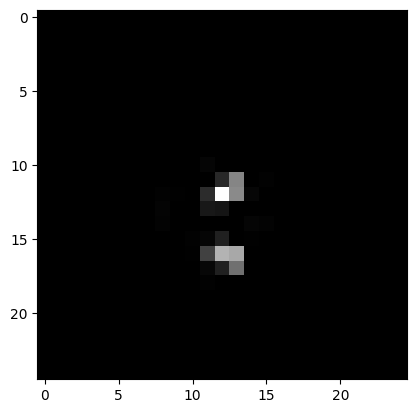

general W-boson general W-boson W-boson W-boson W-boson general general general general general W-boson W-boson general W-boson W-boson W-boson W-boson W-boson general W-boson general W-boson W-boson W-boson W-boson W-boson W-boson W-boson W-boson W-boson W-boson W-boson general general general W-boson general general W-boson W-boson general general W-boson general general general W-boson general W-boson general general W-boson general general general general W-boson W-boson general general W-boson general W-boson general W-boson W-boson general general general W-boson general W-boson general general general general general general W-boson W-boson general W-boson W-boson general W-boson general general general general general W-boson general general general general W-boson W-boson W-boson general general W-boson general W-boson general W-boson general W-boson W-boson W-boson W-boson W-boson W-boson general W-boson W-boson W-boson general W-boson W-boson W-boson W-boson W-boson general 

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    npimg = img.numpy()
    plt.imshow(npimg, cmap='gray')  # Display the first channel of the image grid and use grayscale colormap
    plt.show()

# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
# Show images
imshow(images[0])
# Print labels
print(' '.join(f'{classes[int(labels[j].item())]:5s}' for j in range(batch_size)))



In [11]:
import torch.nn as nn
import torch.nn.functional as F
#from src.utils.model import GlobalAvgPool

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)  # 1 channel as input
        self.dropout1 = nn.Dropout(p=0.1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout(p=0.1)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.dropout3 = nn.Dropout(p=0.1)
        
        # Adjusted for 25x25 input images:
        self.fc1 = nn.Linear(16 * 3 * 3, 120)
        self.dropout4 = nn.Dropout(p=0.1)        
        self.fc2 = nn.Linear(120, 84)
        self.dropout5 = nn.Dropout(p=0.1)
        self.fc3 = nn.Linear(84, 1)

    def forward(self, x):
        x = self.dropout1(F.relu(self.conv1(x)))
        x = self.pool(x)
        x = self.dropout2(F.relu(self.conv2(x)))
        x = self.pool(x)
        x = torch.flatten(x, 1) 
        x = self.dropout3(F.relu(self.fc1(x)))
        x = self.dropout4(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x


net = Net()

class MAlexNet(nn.Module):
    def __init__(self, num_classes, in_channels, drop=0.5, activation_function='relu'):
        super(MAlexNet, self).__init__()

        if activation_function == 'softplus':
            self.act = nn.Softplus
        elif activation_function == 'relu':
            self.act = nn.ReLU
        elif activation_function == 'tanh':
            self.act = nn.Tanh
        else:
            raise ValueError("Only softplus, relu or tanh supported")

        self.features = nn.Sequential(
            nn.Dropout(drop),
            nn.Conv2d(in_channels, 64, 11, stride=4, padding=5, bias=True),
            self.act(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(drop),
            nn.Conv2d(64, 192, 5, padding=2, bias=True),
            self.act(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(drop),
            nn.Conv2d(192, 384, 3, padding=1, bias=True),
            self.act(),
            nn.Dropout(),
            nn.Conv2d(384, 256, 3, padding=1, bias=True),
            self.act(),
            nn.Dropout(),
            nn.Conv2d(256, 128, 3, padding=1, bias=True),
            self.act(),
            #GlobalAvgPool(),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(drop),
            nn.Linear(128, num_classes, bias=True),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x
m_net = MAlexNet(num_classes=1, in_channels=1)

In [12]:
import torch.optim as optim

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [13]:
def train(model):
    for epoch in range(4): 
        running_loss = 0.0
        print("epoch ", epoch, " done")
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.unsqueeze(1)
            labels = labels.float().unsqueeze(1)


            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 10 == 9:    # print every 2000 mini-batches
                #print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
                running_loss = 0.0
    print('Finished Training')

In [14]:
train(net)

epoch  0  done
epoch  1  done
epoch  2  done
epoch  3  done
Finished Training


In [15]:
#PATH = './cifar_net.pth'
#torch.save(net.state_dict(), PATH)

In [16]:
# Put the model in evaluation mode
print("Training: ", net.training)
net.eval()
print("Training: ", net.training)

correct = 0
total = 0
_preds = np.empty((0,1))
_preds_01 = np.empty((0,1))
_labels = np.empty((0,1))


with torch.no_grad():
    for data in testloader: 
        inputs, labels = data
        inputs = inputs.unsqueeze(1)
        labels = labels.float().unsqueeze(1)

        
        outputs = net(inputs)
        
        # Treat the output as a probability using the sigmoid function
        probabilities = torch.sigmoid(outputs)
        _preds = np.append(_preds, probabilities)
        _labels = np.append(_labels, labels)
        

        # Threshold the probabilities to get predicted labels (0 or 1)
        predicted = (probabilities > 0.5).float()
        _preds_01 = np.append(_preds_01, predicted)
        
        print(probabilities.data[1])

        total += labels.size(0)
        # Ensure labels are in the same shape (batch_size, 1) as predicted
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))
print(_preds.shape, _preds[0])


Training:  True
Training:  False
tensor([0.2515])
tensor([0.7945])
tensor([0.7418])
tensor([0.7852])
tensor([0.9444])
tensor([0.7628])
tensor([0.2903])
tensor([0.1317])
tensor([0.3290])
tensor([0.1185])
tensor([0.8069])
tensor([0.4486])
tensor([0.3862])
tensor([0.6800])
tensor([0.8141])
tensor([0.3482])
tensor([0.2121])
tensor([0.8323])
tensor([0.9119])
tensor([0.3611])
tensor([0.8508])
tensor([0.3886])
tensor([0.2932])
tensor([0.3370])
tensor([0.1641])
tensor([0.3925])
tensor([0.1721])
tensor([0.8683])
tensor([0.4675])
tensor([0.2406])
tensor([0.3356])
tensor([0.2454])
tensor([0.7274])
tensor([0.9014])
tensor([0.7797])
tensor([0.8929])
tensor([0.6338])
tensor([0.3742])
tensor([0.8745])
tensor([0.2613])
tensor([0.8433])
tensor([0.2157])
tensor([0.1131])
tensor([0.2595])
tensor([0.2021])
tensor([0.2073])
tensor([0.1685])
tensor([0.5636])
tensor([0.7498])
tensor([0.5718])
tensor([0.2931])
tensor([0.8349])
tensor([0.8808])
tensor([0.7834])
tensor([0.8383])
tensor([0.8819])
tensor([0.1899]

In [17]:
import sys

import numpy as np

import torch
import torch.nn as nn

def enable_dropout(model):
    """ Function to enable the dropout layers during test-time """
    for m in model.modules():
        if m.__class__.__name__.startswith('Dropout'):
            m.train()

#Verb prints out the same index of output for every pass.          
def get_monte_carlo_predictions(data_loader,
                                forward_passes,
                                model,
                                n_classes,
                                n_samples, _verb=False):

    dropout_predictions = np.empty((0, n_samples))

    sigmoid = nn.Sigmoid()

    for fp in range(forward_passes):
        predictions = np.empty((0,))
        model.train()
        enable_dropout(model)
        verb = _verb

        for _, (image, label) in enumerate(data_loader):
            image = image.unsqueeze(1)
            label = label.float().unsqueeze(1)
            if verb:
                print("image shape", image.shape, ", fp_n=",fp)
                print("Training: ", model.training)
            with torch.no_grad():
                output = model(image)
                output = sigmoid(output).squeeze(1)  # shape (n_samples,)
                if verb:
                    print("output shape", output.shape, output[2])
            
            predictions = np.append(predictions, output.cpu().numpy())
            verb = False

        dropout_predictions = np.vstack((dropout_predictions, predictions))        
        # dropout predictions - shape (forward_passes, n_samples)

    # Calculating mean across multiple MCD forward passes 
    mean = np.mean(dropout_predictions, axis=0)  # shape (n_samples,)

    # Calculating standard deviation across multiple MCD forward passes 
    std = np.std(dropout_predictions, axis=0)  # shape (n_samples,)

    epsilon = sys.float_info.min

    # Calculating entropy for binary classification
    entropy = -(mean * np.log(mean + epsilon) + (1 - mean) * np.log(1 - mean + epsilon))  # shape (n_samples,)

    # Calculating mutual information for binary classification
    expected_entropy = -np.mean(dropout_predictions * np.log(dropout_predictions + epsilon) +
                                (1 - dropout_predictions) * np.log(1 - dropout_predictions + epsilon), axis=0)
    mutual_info = entropy - expected_entropy  # shape (n_samples,)

    return mean, std, mutual_info, dropout_predictions

In [64]:
mean,std, mutual_info, dropout_predictions = get_monte_carlo_predictions(data_loader=testloader,
                                forward_passes=100,
                                model=net,
                                n_classes=1,
                                n_samples=test_size,)
#image shape torch.Size([256, 1, 25, 25]) , fp_n= 1

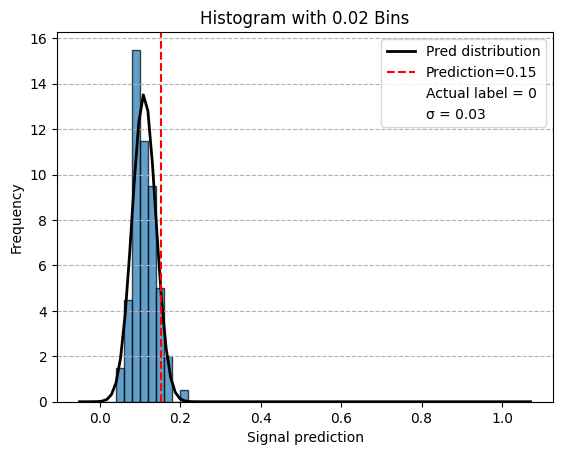

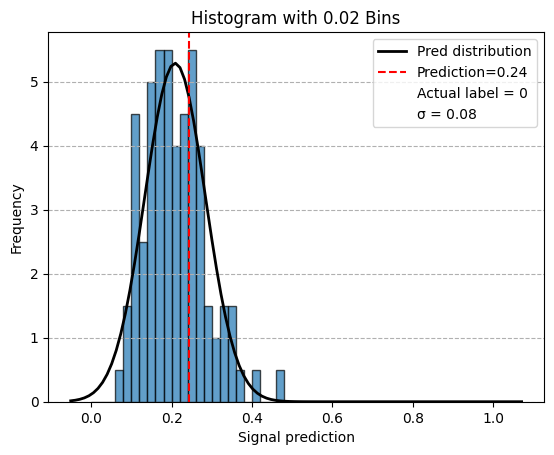

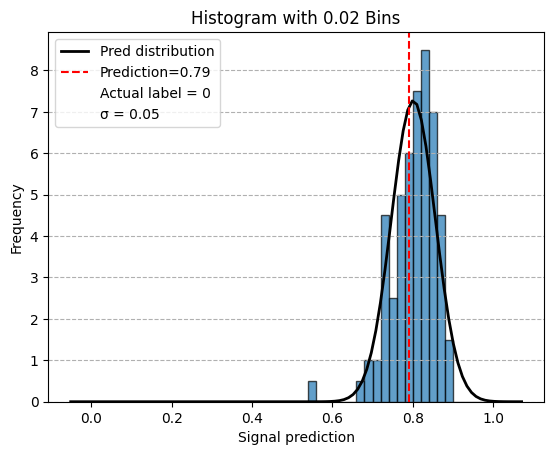

In [22]:
import matplotlib.pyplot as plt
from scipy.stats import norm

def plot_histogram(values, label, threshold=0.02, original_predicition=None, std=None, ):
       # Ensure all values are between 0 and 1
    filtered_values = [v for v in values if 0 <= v <= 1]

    # Set the bin edges based on the given threshold
    bins = [i*threshold for i in range(int(1/threshold) + 2)]  # +2 to include the upper bound

    # Calculate the histogram data without plotting
    y, x, _ = plt.hist(filtered_values, bins=bins, edgecolor='black', alpha=0.7, density=True)
    plt.xlabel(f'Signal prediction')
    plt.ylabel('Frequency')
    plt.title(f'Histogram with {threshold} Bins')
    plt.grid(axis='y', linestyle='--')
    
    # Plot Gaussian distribution
    mean = np.mean(filtered_values)
    std = np.std(filtered_values)
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mean, std)
    plt.plot(x, p, 'k', linewidth=2, label="Pred distribution")
    plt.legend()
    if original_predicition is not None:
        plt.axvline(x=original_predicition, color='red', linestyle='--', label=f'Prediction={original_predicition:.2f}')
        plt.legend()
    current_handles, current_labels = plt.gca().get_legend_handles_labels()
    current_labels.append(f'Actual label = {label:.0f}')
    current_handles.append(plt.Rectangle((0, 0), 0, 0, fc="white", fill=False, edgecolor='none', linewidth=0))
    current_labels.append(f'σ = {std:.2f}')
    current_handles.append(plt.Rectangle((0, 0), 0, 0, fc="white", fill=False, edgecolor='none', linewidth=0))
    plt.legend(handles=current_handles, labels=current_labels)
    plt.show()

# Example
values = dropout_predictions[:, 2]
plot_histogram(values, original_predicition=_preds[2], std=std[2], label=_labels[2])
values = dropout_predictions[:, 770]
plot_histogram(values, original_predicition=_preds[770], std=std[770], label=_labels[770])
values = dropout_predictions[:, 913]
plot_histogram(values, original_predicition=_preds[913], std=std[913], label=_labels[913])

In [23]:
def find_matching_indices(list2, list1):
    """Find indices where value in list1 is <0.05 and value in list2 is between 0.4 and 0.5."""
    matching_indices = []
    
    # Iterate over both lists simultaneously
    for idx, (val1, val2) in enumerate(zip(list1, list2)):
        if val1 < 0.04 and 0.41 <= val2 <= 0.45:
            matching_indices.append(idx)
            
    return matching_indices
print(find_matching_indices(_preds, std))  # This should print [0, 2]

[12155, 16312, 17988]


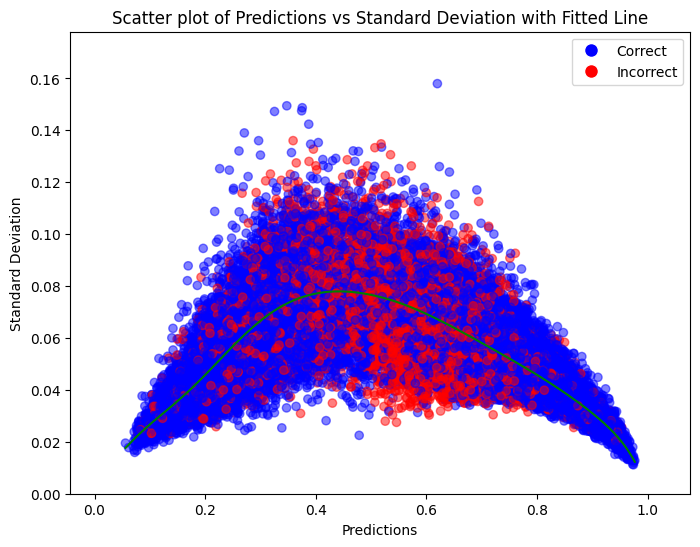

In [24]:
def scatter_plot(preds, std, labels, degree=2):
    if len(preds) != len(std) or len(preds) != len(labels):
        print("All lists should have the same length!")
        return
    
    # Create a list of colors based on the correctness of predictions
    colors = ['blue' if ((p > 0.5 and l == 1) or (p <= 0.5 and l == 0)) else 'red' for p, l in zip(preds, labels)]
    
    plt.figure(figsize=(8, 6))
    plt.scatter(preds, std, color=colors, alpha=0.5)
    
    # Fit a line to the data
    coefficients = np.polyfit(preds, std, degree)
    polynomial = np.poly1d(coefficients)
    
    # Generate y-values based on the fitted polynomial
    xs = np.linspace(min(preds), max(preds), 500)
    fitted_y = polynomial(xs)
    
    # Plot the fitted polynomial
    plt.plot(xs, fitted_y, color='green', label=f'Fitted Polynomial (Degree {degree})')
    
    # Create a custom legend
    blue_patch = plt.Line2D([0], [0], marker='o', color='w', label='Correct', markersize=10, markerfacecolor='blue')
    red_patch = plt.Line2D([0], [0], marker='o', color='w', label='Incorrect', markersize=10, markerfacecolor='red')
    plt.legend(handles=[blue_patch, red_patch])
    
    plt.xlabel("Predictions")
    plt.ylabel("Standard Deviation")
    plt.title("Scatter plot of Predictions vs Standard Deviation with Fitted Line")
    plt.xlim([min(preds)-0.1, max(preds)+0.1])  # assuming predictions are between 0 and 1
    plt.ylim([0, max(std)+0.02])
    plt.show()
    
scatter_plot(_preds, std, _labels, 12)  # Make sure you also provide the 'labels' list when calling the function

(31416,) torch.Size([184, 1])


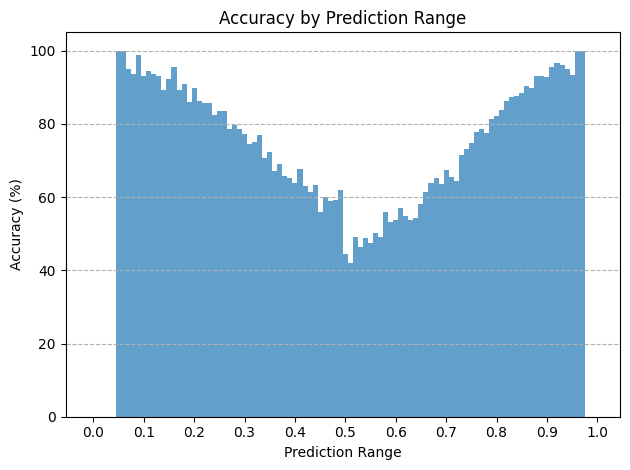

In [46]:
import numpy as np
import matplotlib.pyplot as plt

def plot_accuracy_histogram(predictions, labels, bin_size=0.05):
    if len(predictions) != len(labels):
        print("Predictions and labels must have the same length!")
        return
    
    # Grouping the predictions in bins
    bins = np.arange(0, 1 + bin_size, bin_size)
    bin_indices = np.digitize(predictions, bins) - 1
    
    correct_counts = np.zeros_like(bins[:-1])
    total_counts = np.zeros_like(bins[:-1])
    
    for pred, label in zip(predictions, labels):
        bin_index = min(int(pred / bin_size), len(bins) - 2)  # Ensure it's within range
        if (pred > 0.5 and label == 1) or (pred <= 0.5 and label == 0):
            correct_counts[bin_index] += 1
        total_counts[bin_index] += 1
    
    # Calculating accuracy for each bin
    accuracies = np.divide(correct_counts, total_counts, out=np.zeros_like(correct_counts), where=total_counts!=0) * 100
    
    # Plotting the histogram
    plt.bar(bins[:-1], accuracies, width=bin_size, alpha=0.7)
    plt.xlabel('Prediction Range')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy by Prediction Range')
    plt.ylim(0, 105)  # To make the y-axis range from 0 to 105 for clarity
    plt.grid(axis='y', linestyle='--')

    # Set x-ticks every 0.1 and remove bin labels
    plt.xticks(np.arange(0, 1.1, 0.1))

    plt.tight_layout()
    plt.show()

# Sample usage (assuming _preds and _labels are defined somewhere in your code):
# print(_preds.shape, labels.shape)
# plot_accuracy_histogram(_preds, _labels, bin_size=0.005)



print(_preds.shape, labels.shape)
plot_accuracy_histogram(_preds, _labels, bin_size=0.01)


In [86]:
def salt_and_pepper_noise(img, salt_prob=0.01, pepper_prob=0.01, max_val=275):
    """Apply salt and pepper noise to the image"""
    noisy_img = img.clone().detach()
    
    # Generate mask for salt and pepper noise
    noise_mask = torch.rand_like(img)
    
    salt_mask = (noise_mask <= salt_prob)
    pepper_mask = ((noise_mask > salt_prob) & (noise_mask <= salt_prob + pepper_prob))

    # Apply noise
    noisy_img[salt_mask] = max_val
    noisy_img[pepper_mask] = 0
    
    return noisy_img




import numpy as np
import torch
import torch.nn as nn
import sys

def get_salt_pepper_predictions(data_loader, forward_passes, model, n_classes, n_samples, _verb=False, salt_prob=0.05, pepper_prob=0.05):
    predictions_storage = np.empty((0, n_samples))
    sigmoid = nn.Sigmoid()
    
    for fp in range(forward_passes):
        predictions = np.empty((0,))
        model.eval()  # Ensure model is in eval mode
        verb = _verb

        for _, (image, label) in enumerate(data_loader):
            image = image.unsqueeze(1)
            label = label.float().unsqueeze(1)
            
            noisy_image = salt_and_pepper_noise(image, salt_prob, pepper_prob)
            label = label.float().unsqueeze(1)
            
            if verb:
                print("image shape", noisy_image.shape, ", fp_n=",fp)
            with torch.no_grad():
                output = model(noisy_image)
                output = sigmoid(output).squeeze(1)
                if verb:
                    print("output shape", output.shape, output[2])
            
            predictions = np.append(predictions, output.cpu().numpy())
            verb = False

        predictions_storage = np.vstack((predictions_storage, predictions))

    mean = np.mean(predictions_storage, axis=0)
    std = np.std(predictions_storage, axis=0)
    epsilon = sys.float_info.min

    entropy = -(mean * np.log(mean + epsilon) + (1 - mean) * np.log(1 - mean + epsilon))
    expected_entropy = -np.mean(predictions_storage * np.log(predictions_storage + epsilon) +
                                (1 - predictions_storage) * np.log(1 - predictions_storage + epsilon), axis=0)
    mutual_info = entropy - expected_entropy

    return mean, std, mutual_info, predictions_storage


In [87]:
sp_mean, sp_std, sp_mutual_info, sp_predictions = get_salt_pepper_predictions(data_loader=testloader,
                                forward_passes=5,
                                model=net,
                                n_classes=1,
                                n_samples=test_size)

In [89]:
sp_predictions[:, 2]

array([0.61755276, 0.13122469, 0.01156642, 0.13225935, 0.960473  ])

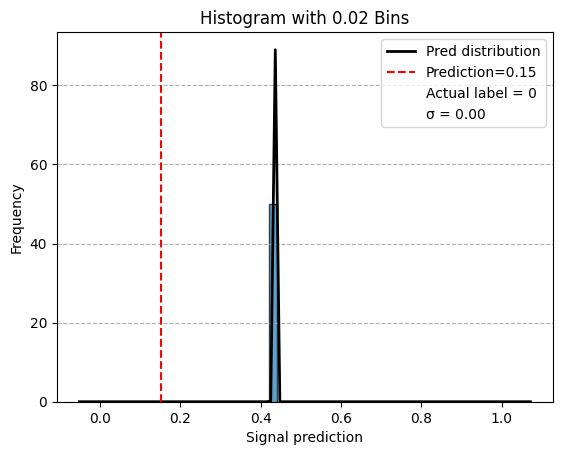

In [69]:
values = sp_predictions[:, 2]
plot_histogram(values, original_predicition=_preds[2], std=sp_std[2], label=_labels[2])